## Content in this Notebook
## Notebook is a part of FREE ML course by Glexey Grigorev. [Link for the Course](https://github.com/alexeygrigorev/mlbookcamp-code/tree/master/course-zoomcamp/04-evaluation)
## Evaluation Metrics for Classification


## 1. Introduction

*Context*

"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]

*Content*

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

    - Customers who left within the last month – the column is called Churn
    - Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
    - Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
    - Demographic info about customers – gender, age range, and if they have partners and dependents

## 2. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

## 3. Data Preparation

In [3]:
df = pd.read_csv('../input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4. Accuracy and dummy model
* Evaluate the model on different thresholds
* Check the accuracy of dummy baselines

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).mean()

0.8034066713981547

In [10]:
from sklearn.metrics import accuracy_score

In [11]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [12]:
# Check the accuracy with different threshold
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


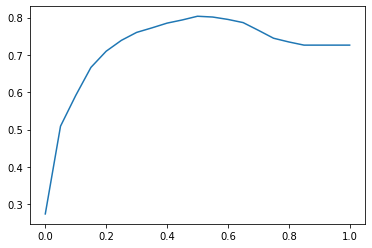

In [13]:
# Plot these results
plt.plot(thresholds, scores)

In [14]:
from collections import Counter

In [15]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [16]:
1 - y_val.mean()

0.7260468417317246

In [17]:
y_val.mean()

0.2739531582682754

### We can see that when all the predictions are False and the accuracy of the model : 0.726 are not churning
### and the actuel model : 0.273 are churning , this is because our data is not balanced.

## 5.  Confusion Table
* Different types of errors and correct decisions
* Arranging them in a table

In [18]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [19]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [20]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [21]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [22]:
# Confusion Matrix in percentage Form
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## 6. Precision and Recall

In [23]:
# Precision
p = tp / (tp + fp)
p

0.6752411575562701

In [24]:
# Recull
r = tp / (tp + fn)
r

0.5440414507772021

In [25]:
tp + fn

386

## 7. ROC Curves

### 7.1 TPR and FRP

In [26]:
# TPR
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [27]:
# FPR
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [28]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [29]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

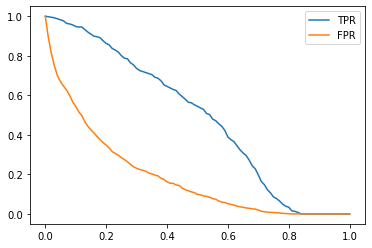

In [30]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### 7.2 Random model

In [31]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [32]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

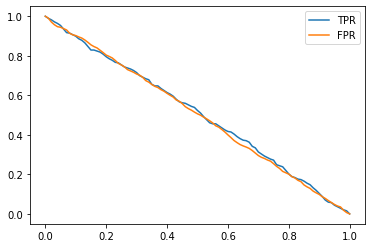

In [33]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### 7.3 Ideal model

In [34]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [35]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [36]:
1 - y_val.mean()

0.7260468417317246

In [37]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [38]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


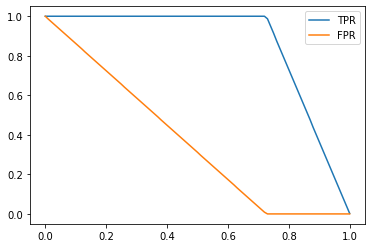

In [39]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### 7.4 Putting everything together

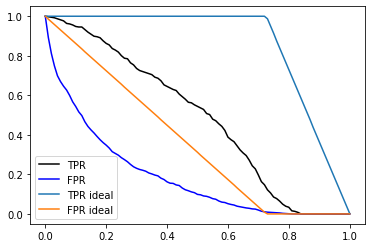

In [40]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

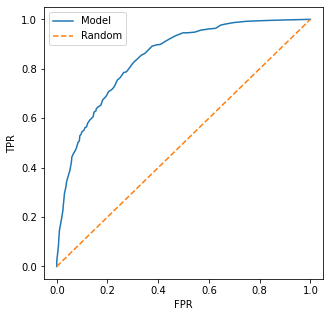

In [41]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

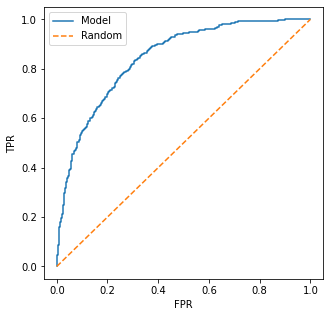

In [42]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## 8. ROC AUC
* Area under the ROC curve - useful metric
* Interpretation of AUC

In [43]:
from sklearn.metrics import auc

In [44]:
auc(fpr, tpr) # Score from implementation
auc(df_scores.fpr, df_scores.tpr) #score from sklearn model

0.8438732975754537

In [45]:
auc(df_ideal.fpr, df_ideal.tpr) # score from ideal model

0.9999430203759136

In [46]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr) # Calculating auc from fpr and tpr generated from previous step

0.8438454408703447

In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred) # Calculate area under curve directly

0.8438454408703447

In [48]:
neg = y_pred[y_val == 0] # Score for negative exemples
pos = y_pred[y_val == 1] # Score for positive exemples

In [49]:
import random

In [50]:
# Randomly selecting postive and negetive class and checking
# If we get postive probability greater than negative probability we increment the score by 1

n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84459

In [51]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

## 9. Cross-Validation
* Evaluating the same model on different subsets of data
* Getting the average prediction and the spread within predictions

In [52]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [53]:
dv, model = train(df_train, y_train, C=0.001)

In [54]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [55]:
y_pred = predict(df_val, dv, model)

In [56]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [57]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.840 +- 0.007
C=1 0.841 +- 0.008
C=5 0.841 +- 0.007
C=10 0.841 +- 0.008


In [58]:
scores

[0.8423515004984653,
 0.8458461627598993,
 0.8325105358217941,
 0.8319990247489928,
 0.8522089046468577]

In [59]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259